# Mirage of Criticality

Phase 1: The Trap — show how a Hawkes MLE with an exponential kernel can report near-critical branching even when the true process is a regime-switching Poisson with no self-excitation (n = 0). We pull the longest-available Fama-French market factor series as a backdrop, then run the simulation sweep over contrast ratios.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

# Find repo root so imports work whether the notebook is run from project root or notebooks/
REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "src").exists():
    for parent in REPO_ROOT.parents:
        if (parent / "src").exists():
            REPO_ROOT = parent
            break

src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

## Market backdrop (Fama-French)

Ken French does not publish intraday factors; the highest frequency is daily (starting 1963-07). Monthly data runs back to 1926-07. Here we load the daily market factor via the shared loader to anchor the timespan and units for the synthetic experiment.

In [2]:
from finance_data.datasets import KenFrenchLoader

loader = KenFrenchLoader(cache_dir=REPO_ROOT / "data" / "famafrench_cache")

ff_daily = loader.load_table("F-F_Research_Data_Factors_daily", table=0, start_date="1926-01-01")
ff_daily = ff_daily.rename(columns={"Mkt-RF": "Mkt_RF"}) / 100.0
ff_daily["Mkt"] = ff_daily["Mkt_RF"] + ff_daily["RF"]

start_date, end_date = ff_daily.index.min().date(), ff_daily.index.max().date()
print(f"Daily market factor window: {start_date} -> {end_date} (Fama-French; daily is highest frequency available)")
ff_daily["Mkt"].describe(percentiles=[0.5, 0.9, 0.99]).to_frame("Mkt")

/workspaces/finance-data-download-test/src/finance_data/datasets.py:62: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fetched = web.DataReader(dataset, "famafrench", start=pdr_start, end=pdr_end)


Daily market factor window: 1926-07-01 -> 2025-10-31 (Fama-French; daily is highest frequency available)


,Mkt
count,26110.000000
mean,0.000429
std,0.010786
min,-0.174100
50%,0.000800
90%,0.010600
99%,0.029991
max,0.156700


## Phase 1: Trap simulation (n = 0 ground truth)

- **Generator:** 2-state regime-switching Poisson with constant intensities (quiet/burst) and sticky regimes (p11 = p22 = 0.95). Regime dwell times are geometric so they are not shortened by the high-rate state.
- **Victim:** Univariate Hawkes MLE with an exponential kernel (branching ratio is the kernel mass, `alpha`).
- **Sweep:** Vary contrast ratio (lambda_high / lambda_low) from 1 to 50, refit the Hawkes model each time, and record the inferred branching ratio \(\hat n\).

In [3]:
from typing import Dict, Tuple

from scipy.optimize import minimize


def simulate_switching_poisson(
    lambda_low: float = 1.0,
    lambda_high: float = 10.0,
    p11: float = 0.95,
    p22: float = 0.95,
    horizon: float = 400.0,
    seed: int | None = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """Simulate a 2-state Poisson process with sticky regimes and no self-excitation."""
    rng = np.random.default_rng(seed)
    t = 0.0
    events = []
    states = []
    state = 0  # 0 = quiet, 1 = burst

    while t < horizon:
        stay_prob = p11 if state == 0 else p22
        switch_prob = 1.0 - stay_prob
        dwell_steps = rng.geometric(switch_prob)
        duration = float(dwell_steps)
        end_t = t + duration
        lam = lambda_high if state == 1 else lambda_low

        n_events = rng.poisson(lam * duration)
        if n_events > 0:
            rel_times = np.sort(rng.random(n_events) * duration)
            events.extend((t + rel_times).tolist())
            states.extend([state] * n_events)

        t = end_t
        state = 1 - state  # alternate regime after the dwell

    return np.array(events), np.array(states)


def hawkes_neg_loglik(params: np.ndarray, events: np.ndarray) -> float:
    """Negative log-likelihood for an exponential-kernel Hawkes with mass alpha."""
    mu, alpha, beta = params
    if mu <= 0 or alpha < 0 or beta <= 0:
        return np.inf

    events = np.asarray(events)
    S = 0.0
    loglik = 0.0
    for i in range(len(events)):
        if i > 0:
            dt = events[i] - events[i - 1]
            S = np.exp(-beta * dt) * (S + 1.0)
        intensity = mu + alpha * beta * S
        if intensity <= 0:
            return np.inf
        loglik += np.log(intensity)

    T_obs = events[-1]
    compensator = mu * T_obs + alpha * np.sum(1.0 - np.exp(-beta * (T_obs - events)))
    return -(loglik - compensator)


def fit_hawkes_exponential(events: np.ndarray) -> Dict[str, float]:
    events = np.asarray(events)
    base_rate = len(events) / events[-1]
    init = np.array([max(base_rate * 0.5, 1e-3), 0.3, 1.0])
    bounds = [(1e-8, None), (0.0, 5.0), (1e-8, None)]

    result = minimize(
        hawkes_neg_loglik,
        x0=init,
        args=(events,),
        method="L-BFGS-B",
        bounds=bounds,
    )

    mu_hat, alpha_hat, beta_hat = result.x
    return {
        "mu": mu_hat,
        "alpha": alpha_hat,
        "beta": beta_hat,
        "branching_ratio": alpha_hat,  # kernel mass for exp-kernel Hawkes
        "result": result,
    }

In [4]:
lambda_low = 1.0
lambda_high = 20.0

events, states = simulate_switching_poisson(
    lambda_low=lambda_low,
    lambda_high=lambda_high,
    p11=0.95,
    p22=0.95,
    horizon=400.0,
    seed=2024,
)
fit = fit_hawkes_exponential(events)

burst_share = (states == 1).mean()
print(f"Simulated events: {len(events):,}; time in burst regime: {burst_share:.2%}")
print(
    f"Hawkes fit (contrast {lambda_high / lambda_low:.1f}): mu={fit['mu']:.3f}, alpha={fit['alpha']:.3f}, beta={fit['beta']:.3f}, n_hat={fit['branching_ratio']:.3f}"
)

Simulated events: 4,002; time in burst regime: 94.58%
Hawkes fit (contrast 20.0): mu=0.532, alpha=0.946, beta=1.650, n_hat=0.946


### Contrast sweep and "killer" plot

In [5]:
contrast_grid = np.concatenate([
    np.linspace(1, 10, 6),
    np.linspace(12, 50, 10),
])

sweep_records = []
for idx, contrast in enumerate(contrast_grid):
    lam_high = lambda_low * contrast
    events, states = simulate_switching_poisson(
        lambda_low=lambda_low,
        lambda_high=lam_high,
        p11=0.95,
        p22=0.95,
        horizon=400.0,
        seed=100 + idx,
    )
    fit = fit_hawkes_exponential(events)
    sweep_records.append(
        {
            "contrast": contrast,
            "lambda_low": lambda_low,
            "lambda_high": lam_high,
            "events": len(events),
            "branching_ratio_hat": fit["branching_ratio"],
            "mu_hat": fit["mu"],
            "beta_hat": fit["beta"],
            "success": fit["result"].success,
        }
    )

sweep_df = pd.DataFrame(sweep_records).sort_values("contrast").reset_index(drop=True)
sweep_df

,contrast,lambda_low,lambda_high,events,branching_ratio_hat,mu_hat,beta_hat,success
0,1.000000,1.0,1.000000,459,0.000000,1.038381,0.948519,True
1,2.800000,1.0,2.800000,692,0.696156,0.471629,0.178950,True
2,4.600000,1.0,4.600000,1149,0.806818,0.554137,0.493942,True
3,6.400000,1.0,6.400000,1441,0.850986,0.493602,0.841655,True
4,8.200000,1.0,8.200000,1809,0.893828,0.478757,0.926627,True
5,10.000000,1.0,10.000000,1841,0.884407,0.536183,1.229717,True
6,12.000000,1.0,12.000000,3181,0.933159,0.502458,1.106315,True
7,16.222222,1.0,16.222222,3615,0.933765,0.591896,1.511534,True
8,20.444444,1.0,20.444444,2965,0.917860,0.568706,1.934531,True
9,24.666667,1.0,24.666667,5000,0.955382,0.548504,2.517958,True


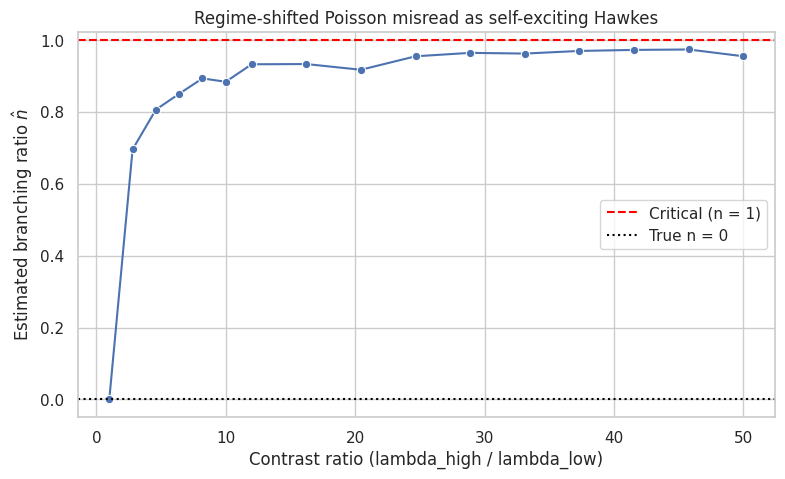

In [6]:
fig, ax = plt.subplots()
sns.lineplot(data=sweep_df, x="contrast", y="branching_ratio_hat", marker="o", ax=ax)
ax.axhline(1.0, color="red", linestyle="--", label="Critical (n = 1)")
ax.axhline(0.0, color="black", linestyle=":", label="True n = 0")
ax.set_xlabel("Contrast ratio (lambda_high / lambda_low)")
ax.set_ylabel(r"Estimated branching ratio $\hat n$")
ax.set_title("Regime-shifted Poisson misread as self-exciting Hawkes")
ax.legend()
plt.show()

**Takeaway:** even though the generator has no feedback (true branching ratio = 0), the Hawkes MLE interprets persistent jumps in the baseline rate as endogenous clustering. As the contrast between quiet and burst regimes widens, \(\hat n\) climbs toward the critical boundary near 1, creating a "mirage of criticality." The effect comes purely from unmodeled rate shifts, not self-excitation.